# American Sign Language (ASL) Image Recognition

## Introduction

## Loading in dataset

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile  
from sklearn.datasets import load_files
from keras.utils import np_utils
from keras.preprocessing import image                  
from tqdm import tqdm

# For compiling model
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D

# For transfer learning
import scipy
import keras.applications.vgg16 as vgg16
import keras.applications.vgg19 as vgg19
import keras.applications.resnet50 as resnet50

# For confusion matrix calculation/visualization
import tensorflow as tf
import seaborn as sn
import pandas as pd

models_dir = 'saved_models'
data_dir = 'data'
bottleneck_feat_dir = 'bottleneck_features'

Using TensorFlow backend.


### Dividing data into training, validation, and testing sets

Now that preprocessing the images is completed (see `data_preprocessing.ipynb` notebook), the full dataset will be split into training, validation, and testing sets. The testing set will be all the images from one subject to mirror the "Spelling It Out" paper's method so the benchmark model can be compared. The rest of the images will be randomly split; 80% of images for training, 20% of the images for validation.

In [2]:
def load_dataset(path, n_categories=24):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    # Hot encode categories to matrix
    image_targets = np_utils.to_categorical(np.array(data['target']), n_categories)
    return image_files, image_targets

def move_data_by_category(container_dir, regex_file_format='.*png'):
    '''Move data into a directory based on category'''
    # Still check if files are images
    file_list = [x for x in os.listdir(container_dir) if re.search(regex_file_format, x)]
    # Get numerical string (note that 1 digits are represented w/ 2 digits) 
    letters = {x.split('_')[0] for x in file_list}
    
    for letter in letters:
        # Only images that match letter
        images_with_letter = [filename for filename in file_list if filename.split('_')[0] == letter]
        # Add images to sub directory
        new_categ_path = os.path.join(container_dir, letter)
        if not os.path.exists(new_categ_path):
            os.makedirs(new_categ_path)
#         print('Created {new_categ_path} dir with {len(images_with_letter)} items')
        for img_filename in images_with_letter:
            path = os.path.join(container_dir, img_filename)
            new_path = os.path.join(new_categ_path, img_filename)            
            os.rename(path, new_path)
    # TODO: Check if any files were skipped (improperly named?)
        

def get_testing_data(data_dir, subject_num='4'):
    '''Get all data/images pertaining to one subject'''
    # Only search in directory for images with that subject
    file_list = [x for x in os.listdir(data_dir) if re.search('\d+_{}_\d*\.png'.format(subject_num), x)]
    
    # Make a new testing data directory if doesn't exist
    testing_dir = os.path.join(data_dir, 'test')
    if not os.path.exists(testing_dir):
        os.makedirs(testing_dir)
        
    # Move images of particular subject into testing directory
    for image_filename in file_list:
        # file is **_n_****.png where n is an integer representing a subject
        _, subject, _ = image_filename.split('_')
        # Move file into testing directory
        path = os.path.join(data_dir, image_filename)
        new_path = os.path.join(testing_dir, image_filename)
        os.rename(path, new_path)
        
    # Move each image file's numerical str representing letters found in testing into own category directory
    move_data_by_category(testing_dir)
    
    return load_dataset(testing_dir)


def get_training_validation_data(data_dir, ratio=0.8):
    '''Randomly split data into training and validation sets'''
    # Only search in directory for images
    file_list = [x for x in os.listdir(data_dir) if re.search('.*png', x)]
    
    # Make a new training & validation data directory if doesn't exist
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)
        
    # Randomly split file list into training and vaidation sets
    np.random.shuffle(file_list)
    split_int = int(ratio * len(file_list))
    train_list = file_list[:split_int]
    valid_list = file_list[split_int:]
    
    # Move images of particular subject into testing directory
    for filenames, new_dir in [(train_list, train_dir), (valid_list, valid_dir)]:
        for image_filename in filenames:
            # Move file into testing directory
            path = os.path.join(data_dir, image_filename)
            new_path = os.path.join(new_dir, image_filename)
            os.rename(path, new_path)

        # Move each image file's numerical str representing letters found in testing into own category directory
        move_data_by_category(new_dir)
    
    return (load_dataset(train_dir), load_dataset(valid_dir))

In [3]:
# Manually set if the data is RGB
is_rgb = True

test_data, test_targets = get_testing_data(data_dir)
train, valid = get_training_validation_data(data_dir)
# Separated data and its targets
train_data, train_targets = train
valid_data, valid_targets = valid

### Display some of the images

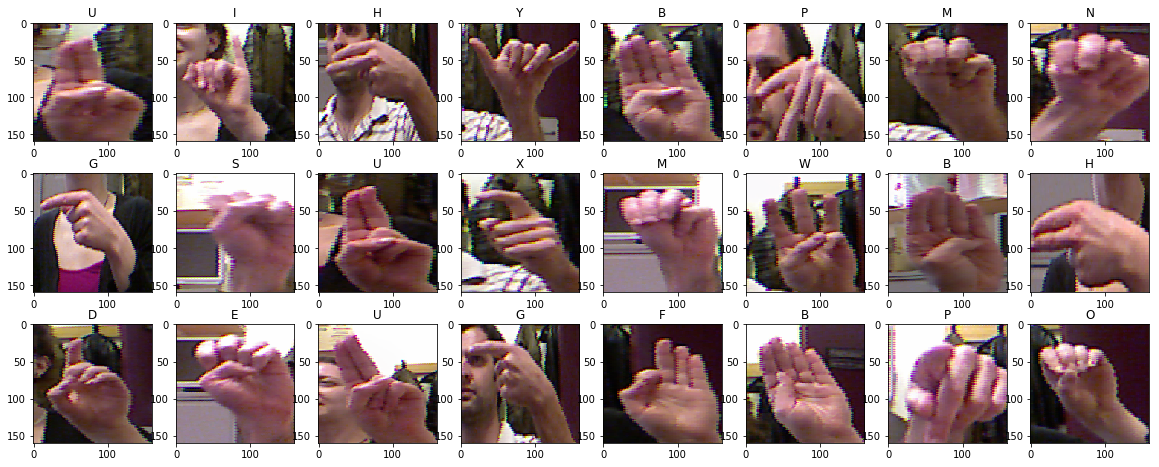

In [4]:
np.random.seed(8675309)
%matplotlib inline

# Display image previews below
plt.figure(figsize=(20,55))
columns = 8
n = 1

# Randomly choose images to display (with label)
for image_path in np.random.choice(train_data, 24, replace=False):
    img = Image.open(image_path)
    plt.subplot(20, columns, n)
    n+=1
    plt.imshow(img)
    letter = image_path.split('/')[-1][:2]
    letter = chr(int(letter)+65)
    plt.title(letter)

### Preparing the model

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
valid_tensors = paths_to_tensor(valid_data).astype('float32')
test_tensors = paths_to_tensor(test_data).astype('float32')

In [ ]:
# Prepare training data separately since this is usually large
train_tensors = paths_to_tensor(train_data).astype('float32')

## Basic CNN model from scratch

### Building basic model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
#Convo 224, 224, 1
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 1)))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(GlobalAveragePooling2D())
#Dense; 24 for each handshape 
model.add(Dense(24, activation='softmax'))


model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training basic model

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 16

# Create a saved models directory
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath=f'{models_dir}/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Evaluating basic model

In [ ]:
handshape_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(handshape_predictions)==np.argmax(test_targets, axis=1))/len(handshape_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

## Transfer Learning with VGG16

### Preparing the model

In [ ]:
# Define image size to use for given model
n_pixels = 80
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

In [ ]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

In [ ]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

### Extract Bottleneck Features for Training Set

In [ ]:
# Name & path of bottleneck features
feat_train_name = 'vgg16_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg16 model + remove final classification layers
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg16_input_train = vgg16.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg16_input_train)
    features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

### Extract Bottleneck Features for Validation Set

In [ ]:
# Name & path of bottleneck features
feat_valid_name = 'vgg16_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg16_input_valid = vgg16.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg16_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

### Extract Bottleneck Features for Test Set

In [ ]:
# Name & path of bottleneck features
feat_test_name = 'vgg16_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg16_input_test = vgg16.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg16_input_test)
    features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

### Building model

In [ ]:
features.shape
type(features)
features_ = features

In [ ]:
# 3 CNN Layers
model = Sequential()

model.add(Conv2D(filters=256, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=1))

model.add(Conv2D(filters=32, kernel_size=1))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
epochs = 50
batchsize = 500
model_weights_path = '{}/vgg16_{}.best_batch{}_epoch{}.hdf5'.format(models_dir,model_name,batchsize,epochs)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

## Transfer Learning with VGG19

### Preparing the model

In [ ]:
# Define image size to use for given model
n_pixels = 160
# Define a model name for recorcs
model_name = 'model_{}px'.format(n_pixels)

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

In [ ]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

In [ ]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

### Extract Bottleneck Features for Training Set

In [ ]:
# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg19 model + remove final classification layers
model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists('vgg19_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('vgg19_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg19_input_train = vgg19.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg19_input_train)
    features = np.squeeze(features)
    np.savez('vgg19_features_train', features=features)

print('bottleneck features saved (train)')

### Extract Bottleneck Features for Validation Set

In [ ]:
# Obtain bottleneck features (valid)
if os.path.exists('vgg19_features_valid.npz'):
    print('bottleneck features detected (valid)')
    features_valid = np.load('vgg19_features_valid.npz')['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg19_input_valid = vgg19.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg19_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez('vgg19_features_valid', features_test=features_valid)
print('bottleneck features saved (valid)')

### Extract Bottleneck Features for Test Set

In [ ]:
# Obtain bottleneck features (test)
if os.path.exists('vgg19_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('vgg19_features_test.npz')['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg19_input_test = vgg19.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg19_input_test)
    features_test = np.squeeze(features_test)
    np.savez('vgg19_features_test', features_test=features_test)
print('bottleneck features saved (test)')

### Building model

In [ ]:
# Shallow NN
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=256, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



In [ ]:
epochs = 256
batchsize = 512
model_weights_path = f'{models_dir}/vgg19_new_{model_name}.best_batch{batchsize}_epoch{epochs}.hdf5'

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

## Transfer Learning with ResNet50

### Preparing the model

In [5]:
# Define image size to use for given model
n_pixels = 197
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [6]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

  1%|          | 69/10599 [00:00<00:15, 686.63it/s]

Preparing to create valid tensors


100%|██████████| 10599/10599 [00:16<00:00, 658.26it/s]


valid tensors prepared


In [13]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

  0%|          | 58/12782 [00:00<00:22, 577.28it/s]

Preparing to create test tensors


100%|██████████| 12782/12782 [00:21<00:00, 594.40it/s]


test tensors prepared


In [12]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

Preparing to create train tensors
train tensors prepared


### Extract Bottleneck Features for Training Set

In [8]:
# Name & path of bottleneck features
feat_train_name = 'resnet50_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load resnet50 model + remove final classification layers
model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    resnet50_input_train = resnet50.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(resnet50_input_train)
#     features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

data loaded
model loaded
bottleneck features detected (train)
bottleneck features saved (train)


### Extract Bottleneck Features for Validation Set

In [9]:
# Name & path of bottleneck features
feat_valid_name = 'resnet50_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    resnet50_input_valid = resnet50.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(resnet50_input_valid)
#     features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

bottleneck features detected (valid)
bottleneck features saved (valid)


### Extract Bottleneck Features for Test Set

In [10]:
# Name & path of bottleneck features
feat_test_name = 'resnet50_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    resnet50_input_test = resnet50.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(resnet50_input_test)
#     features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features detected (test)
bottleneck features saved (test)


### Building model

In [11]:
# 3 CNN Layers
from keras.layers import MaxPooling2D

model = Sequential()

model.add(Conv2D(filters=512, kernel_size=1, input_shape=features.shape[1:]))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=1))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=1))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=1))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1, 512)         1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         131328    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         32896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 128)         0         
__________

In [17]:
epochs = 1536
batchsize = 8192
model_details = 'resnet50_{}_batch{}_epoch{}'.format(model_name,batchsize,epochs)
model_weights_path = '{}/{}.hdf5'.format(models_dir,model_details)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

Train on 42393 samples, validate on 10599 samples
Epoch 1/1536
Epoch 00000: val_loss improved from inf to 0.05668, saving model to saved_models/resnet50_rgbModel_197px_batch8192_epoch1536.hdf5
0s - loss: 0.0279 - acc: 0.9910 - val_loss: 0.0567 - val_acc: 0.9825
Epoch 2/1536
Epoch 00001: val_loss did not improve
0s - loss: 0.0281 - acc: 0.9908 - val_loss: 0.0627 - val_acc: 0.9791
Epoch 3/1536
Epoch 00002: val_loss did not improve
0s - loss: 0.0797 - acc: 0.9749 - val_loss: 0.5369 - val_acc: 0.8987
Epoch 4/1536
Epoch 00003: val_loss did not improve
0s - loss: 0.6408 - acc: 0.8752 - val_loss: 0.5027 - val_acc: 0.8886
Epoch 5/1536
Epoch 00004: val_loss did not improve
0s - loss: 0.2616 - acc: 0.9353 - val_loss: 0.0622 - val_acc: 0.9792
Epoch 6/1536
Epoch 00005: val_loss did not improve
0s - loss: 0.0330 - acc: 0.9889 - val_loss: 0.0580 - val_acc: 0.9808
Epoch 7/1536
Epoch 00006: val_loss did not improve
0s - loss: 0.0278 - acc: 0.9913 - val_loss: 0.0599 - val_acc: 0.9802
Epoch 8/1536
Epoch

Epoch 00067: val_loss did not improve
0s - loss: 0.9674 - acc: 0.8531 - val_loss: 0.0711 - val_acc: 0.9772
Epoch 69/1536
Epoch 00068: val_loss did not improve
0s - loss: 0.0397 - acc: 0.9863 - val_loss: 0.0665 - val_acc: 0.9784
Epoch 70/1536
Epoch 00069: val_loss did not improve
0s - loss: 0.0344 - acc: 0.9881 - val_loss: 0.0697 - val_acc: 0.9774
Epoch 71/1536
Epoch 00070: val_loss did not improve
0s - loss: 0.0307 - acc: 0.9896 - val_loss: 0.0638 - val_acc: 0.9784
Epoch 72/1536
Epoch 00071: val_loss did not improve
0s - loss: 0.0362 - acc: 0.9873 - val_loss: 0.2152 - val_acc: 0.9420
Epoch 73/1536
Epoch 00072: val_loss did not improve
0s - loss: 0.1965 - acc: 0.9412 - val_loss: 0.0788 - val_acc: 0.9747
Epoch 74/1536
Epoch 00073: val_loss did not improve
0s - loss: 0.0325 - acc: 0.9886 - val_loss: 0.0643 - val_acc: 0.9797
Epoch 75/1536
Epoch 00074: val_loss did not improve
0s - loss: 0.0266 - acc: 0.9910 - val_loss: 0.1040 - val_acc: 0.9671
Epoch 76/1536
Epoch 00075: val_loss did not im

Epoch 00135: val_loss did not improve
0s - loss: 0.1914 - acc: 0.9507 - val_loss: 0.0631 - val_acc: 0.9812
Epoch 137/1536
Epoch 00136: val_loss did not improve
0s - loss: 0.0254 - acc: 0.9914 - val_loss: 0.0658 - val_acc: 0.9802
Epoch 138/1536
Epoch 00137: val_loss did not improve
0s - loss: 0.0269 - acc: 0.9912 - val_loss: 0.0734 - val_acc: 0.9776
Epoch 139/1536
Epoch 00138: val_loss did not improve
0s - loss: 0.0325 - acc: 0.9890 - val_loss: 0.0725 - val_acc: 0.9779
Epoch 140/1536
Epoch 00139: val_loss did not improve
0s - loss: 0.1132 - acc: 0.9682 - val_loss: 0.7311 - val_acc: 0.8562
Epoch 141/1536
Epoch 00140: val_loss did not improve
0s - loss: 1.3693 - acc: 0.7893 - val_loss: 0.1095 - val_acc: 0.9679
Epoch 142/1536
Epoch 00141: val_loss did not improve
0s - loss: 0.0486 - acc: 0.9841 - val_loss: 0.0652 - val_acc: 0.9797
Epoch 143/1536
Epoch 00142: val_loss did not improve
0s - loss: 0.0320 - acc: 0.9890 - val_loss: 0.0631 - val_acc: 0.9808
Epoch 144/1536
Epoch 00143: val_loss di

Epoch 00202: val_loss did not improve
0s - loss: 0.0285 - acc: 0.9907 - val_loss: 0.0641 - val_acc: 0.9806
Epoch 204/1536
Epoch 00203: val_loss did not improve
0s - loss: 0.0252 - acc: 0.9917 - val_loss: 0.0600 - val_acc: 0.9820
Epoch 205/1536
Epoch 00204: val_loss did not improve
0s - loss: 0.0246 - acc: 0.9918 - val_loss: 0.0880 - val_acc: 0.9730
Epoch 206/1536
Epoch 00205: val_loss did not improve
0s - loss: 0.1903 - acc: 0.9544 - val_loss: 0.4475 - val_acc: 0.8975
Epoch 207/1536
Epoch 00206: val_loss did not improve
0s - loss: 0.5389 - acc: 0.8788 - val_loss: 0.1277 - val_acc: 0.9626
Epoch 208/1536
Epoch 00207: val_loss did not improve
0s - loss: 0.0410 - acc: 0.9864 - val_loss: 0.0593 - val_acc: 0.9809
Epoch 209/1536
Epoch 00208: val_loss did not improve
0s - loss: 0.0267 - acc: 0.9914 - val_loss: 0.0608 - val_acc: 0.9808
Epoch 210/1536
Epoch 00209: val_loss did not improve
0s - loss: 0.0245 - acc: 0.9922 - val_loss: 0.0643 - val_acc: 0.9788
Epoch 211/1536
Epoch 00210: val_loss di

Epoch 00270: val_loss did not improve
0s - loss: 0.0263 - acc: 0.9908 - val_loss: 0.0636 - val_acc: 0.9807
Epoch 272/1536
Epoch 00271: val_loss did not improve
0s - loss: 0.0270 - acc: 0.9909 - val_loss: 0.0633 - val_acc: 0.9803
Epoch 273/1536
Epoch 00272: val_loss did not improve
0s - loss: 0.0231 - acc: 0.9922 - val_loss: 0.0679 - val_acc: 0.9794
Epoch 274/1536
Epoch 00273: val_loss did not improve
0s - loss: 0.0231 - acc: 0.9921 - val_loss: 0.0719 - val_acc: 0.9778
Epoch 275/1536
Epoch 00274: val_loss did not improve
0s - loss: 0.6097 - acc: 0.9009 - val_loss: 1.5800 - val_acc: 0.8256
Epoch 276/1536
Epoch 00275: val_loss did not improve
0s - loss: 0.8353 - acc: 0.8866 - val_loss: 0.0743 - val_acc: 0.9788
Epoch 277/1536
Epoch 00276: val_loss did not improve
0s - loss: 0.0316 - acc: 0.9886 - val_loss: 0.0676 - val_acc: 0.9807
Epoch 278/1536
Epoch 00277: val_loss did not improve
0s - loss: 0.0247 - acc: 0.9916 - val_loss: 0.0650 - val_acc: 0.9810
Epoch 279/1536
Epoch 00278: val_loss di

Epoch 00338: val_loss did not improve
0s - loss: 0.5963 - acc: 0.8869 - val_loss: 0.3769 - val_acc: 0.9202
Epoch 340/1536
Epoch 00339: val_loss did not improve
0s - loss: 0.1676 - acc: 0.9583 - val_loss: 0.0600 - val_acc: 0.9808
Epoch 341/1536
Epoch 00340: val_loss did not improve
0s - loss: 0.0211 - acc: 0.9930 - val_loss: 0.0568 - val_acc: 0.9809
Epoch 342/1536
Epoch 00341: val_loss did not improve
0s - loss: 0.0200 - acc: 0.9928 - val_loss: 0.0606 - val_acc: 0.9816
Epoch 343/1536
Epoch 00342: val_loss did not improve
0s - loss: 0.0181 - acc: 0.9943 - val_loss: 0.0557 - val_acc: 0.9826
Epoch 344/1536
Epoch 00343: val_loss did not improve
0s - loss: 0.0207 - acc: 0.9933 - val_loss: 0.0725 - val_acc: 0.9790
Epoch 345/1536
Epoch 00344: val_loss did not improve
0s - loss: 0.3611 - acc: 0.9295 - val_loss: 0.6484 - val_acc: 0.8802
Epoch 346/1536
Epoch 00345: val_loss did not improve
0s - loss: 0.3042 - acc: 0.9299 - val_loss: 0.0583 - val_acc: 0.9825
Epoch 347/1536
Epoch 00346: val_loss di

Epoch 00405: val_loss did not improve
0s - loss: 0.0223 - acc: 0.9918 - val_loss: 0.0687 - val_acc: 0.9797
Epoch 407/1536
Epoch 00406: val_loss did not improve
0s - loss: 0.0217 - acc: 0.9925 - val_loss: 0.0703 - val_acc: 0.9800
Epoch 408/1536
Epoch 00407: val_loss did not improve
0s - loss: 0.0201 - acc: 0.9929 - val_loss: 0.0683 - val_acc: 0.9804
Epoch 409/1536
Epoch 00408: val_loss did not improve
0s - loss: 0.5833 - acc: 0.9196 - val_loss: 0.8031 - val_acc: 0.8539
Epoch 410/1536
Epoch 00409: val_loss did not improve
0s - loss: 0.4012 - acc: 0.9150 - val_loss: 0.0654 - val_acc: 0.9808
Epoch 411/1536
Epoch 00410: val_loss did not improve
0s - loss: 0.0218 - acc: 0.9925 - val_loss: 0.0635 - val_acc: 0.9809
Epoch 412/1536
Epoch 00411: val_loss did not improve
0s - loss: 0.0201 - acc: 0.9928 - val_loss: 0.0624 - val_acc: 0.9808
Epoch 413/1536
Epoch 00412: val_loss did not improve
0s - loss: 0.0207 - acc: 0.9926 - val_loss: 0.0603 - val_acc: 0.9818
Epoch 414/1536
Epoch 00413: val_loss di

Epoch 00471: val_loss did not improve
0s - loss: 0.0180 - acc: 0.9945 - val_loss: 0.0586 - val_acc: 0.9825
Epoch 473/1536
Epoch 00472: val_loss did not improve
0s - loss: 0.0165 - acc: 0.9948 - val_loss: 0.0582 - val_acc: 0.9817
Epoch 474/1536
Epoch 00473: val_loss did not improve
0s - loss: 0.0268 - acc: 0.9906 - val_loss: 0.4073 - val_acc: 0.9280
Epoch 475/1536
Epoch 00474: val_loss did not improve
0s - loss: 0.7514 - acc: 0.8696 - val_loss: 0.6524 - val_acc: 0.8744
Epoch 476/1536
Epoch 00475: val_loss did not improve
0s - loss: 0.2067 - acc: 0.9556 - val_loss: 0.0643 - val_acc: 0.9800
Epoch 477/1536
Epoch 00476: val_loss did not improve
0s - loss: 0.0243 - acc: 0.9915 - val_loss: 0.0592 - val_acc: 0.9820
Epoch 478/1536
Epoch 00477: val_loss did not improve
0s - loss: 0.0221 - acc: 0.9930 - val_loss: 0.0692 - val_acc: 0.9783
Epoch 479/1536
Epoch 00478: val_loss did not improve
0s - loss: 0.0223 - acc: 0.9927 - val_loss: 0.0569 - val_acc: 0.9829
Epoch 480/1536
Epoch 00479: val_loss di

Epoch 00539: val_loss did not improve
0s - loss: 0.7497 - acc: 0.8792 - val_loss: 0.5870 - val_acc: 0.8824
Epoch 541/1536
Epoch 00540: val_loss did not improve
0s - loss: 0.2050 - acc: 0.9509 - val_loss: 0.0568 - val_acc: 0.9819
Epoch 542/1536
Epoch 00541: val_loss did not improve
0s - loss: 0.0186 - acc: 0.9937 - val_loss: 0.0564 - val_acc: 0.9827
Epoch 543/1536
Epoch 00542: val_loss did not improve
0s - loss: 0.0170 - acc: 0.9945 - val_loss: 0.0537 - val_acc: 0.9828
Epoch 544/1536
Epoch 00543: val_loss did not improve
0s - loss: 0.0155 - acc: 0.9948 - val_loss: 0.0577 - val_acc: 0.9817
Epoch 545/1536
Epoch 00544: val_loss did not improve
0s - loss: 0.0150 - acc: 0.9950 - val_loss: 0.0641 - val_acc: 0.9807
Epoch 546/1536
Epoch 00545: val_loss did not improve
0s - loss: 0.0216 - acc: 0.9926 - val_loss: 0.4043 - val_acc: 0.9341
Epoch 547/1536
Epoch 00546: val_loss did not improve
0s - loss: 1.0676 - acc: 0.8429 - val_loss: 1.0293 - val_acc: 0.8567
Epoch 548/1536
Epoch 00547: val_loss di

Epoch 00607: val_loss did not improve
0s - loss: 0.0155 - acc: 0.9947 - val_loss: 0.0562 - val_acc: 0.9847
Epoch 609/1536
Epoch 00608: val_loss did not improve
0s - loss: 0.0146 - acc: 0.9950 - val_loss: 0.0576 - val_acc: 0.9841
Epoch 610/1536
Epoch 00609: val_loss did not improve
0s - loss: 0.2814 - acc: 0.9457 - val_loss: 0.9728 - val_acc: 0.8728
Epoch 611/1536
Epoch 00610: val_loss did not improve
0s - loss: 0.4841 - acc: 0.9130 - val_loss: 0.0597 - val_acc: 0.9816
Epoch 612/1536
Epoch 00611: val_loss did not improve
0s - loss: 0.0172 - acc: 0.9941 - val_loss: 0.0606 - val_acc: 0.9811
Epoch 613/1536
Epoch 00612: val_loss did not improve
0s - loss: 0.0167 - acc: 0.9942 - val_loss: 0.0546 - val_acc: 0.9841
Epoch 614/1536
Epoch 00613: val_loss did not improve
0s - loss: 0.0151 - acc: 0.9951 - val_loss: 0.0523 - val_acc: 0.9846
Epoch 615/1536
Epoch 00614: val_loss did not improve
0s - loss: 0.0150 - acc: 0.9950 - val_loss: 0.0582 - val_acc: 0.9839
Epoch 616/1536
Epoch 00615: val_loss di

Epoch 00674: val_loss did not improve
0s - loss: 0.6127 - acc: 0.8924 - val_loss: 0.0875 - val_acc: 0.9760
Epoch 676/1536
Epoch 00675: val_loss did not improve
0s - loss: 0.0220 - acc: 0.9928 - val_loss: 0.0652 - val_acc: 0.9826
Epoch 677/1536
Epoch 00676: val_loss did not improve
0s - loss: 0.0155 - acc: 0.9949 - val_loss: 0.0629 - val_acc: 0.9823
Epoch 678/1536
Epoch 00677: val_loss did not improve
0s - loss: 0.0147 - acc: 0.9951 - val_loss: 0.0651 - val_acc: 0.9810
Epoch 679/1536
Epoch 00678: val_loss did not improve
0s - loss: 0.0159 - acc: 0.9946 - val_loss: 0.0640 - val_acc: 0.9818
Epoch 680/1536
Epoch 00679: val_loss did not improve
0s - loss: 0.0149 - acc: 0.9954 - val_loss: 0.0603 - val_acc: 0.9819
Epoch 681/1536
Epoch 00680: val_loss did not improve
0s - loss: 0.0215 - acc: 0.9930 - val_loss: 0.5990 - val_acc: 0.9309
Epoch 682/1536
Epoch 00681: val_loss did not improve
0s - loss: 1.0180 - acc: 0.8641 - val_loss: 1.0738 - val_acc: 0.8440
Epoch 683/1536
Epoch 00682: val_loss di

Epoch 00741: val_loss did not improve
0s - loss: 0.0186 - acc: 0.9939 - val_loss: 0.0565 - val_acc: 0.9836
Epoch 743/1536
Epoch 00742: val_loss did not improve
0s - loss: 0.0155 - acc: 0.9947 - val_loss: 0.0568 - val_acc: 0.9831
Epoch 744/1536
Epoch 00743: val_loss did not improve
0s - loss: 0.0271 - acc: 0.9911 - val_loss: 0.1561 - val_acc: 0.9599
Epoch 745/1536
Epoch 00744: val_loss did not improve
0s - loss: 0.6611 - acc: 0.8946 - val_loss: 0.5551 - val_acc: 0.8919
Epoch 746/1536
Epoch 00745: val_loss improved from 0.05155 to 0.05154, saving model to saved_models/resnet50_rgbModel_197px_batch8192_epoch1536.hdf5
0s - loss: 0.1827 - acc: 0.9618 - val_loss: 0.0515 - val_acc: 0.9845
Epoch 747/1536
Epoch 00746: val_loss did not improve
0s - loss: 0.0167 - acc: 0.9943 - val_loss: 0.0530 - val_acc: 0.9842
Epoch 748/1536
Epoch 00747: val_loss did not improve
0s - loss: 0.0152 - acc: 0.9947 - val_loss: 0.0543 - val_acc: 0.9838
Epoch 749/1536
Epoch 00748: val_loss did not improve
0s - loss: 0

Epoch 00808: val_loss did not improve
0s - loss: 0.0119 - acc: 0.9962 - val_loss: 0.0596 - val_acc: 0.9838
Epoch 810/1536
Epoch 00809: val_loss did not improve
0s - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0735 - val_acc: 0.9799
Epoch 811/1536
Epoch 00810: val_loss did not improve
0s - loss: 0.9892 - acc: 0.8834 - val_loss: 1.1439 - val_acc: 0.8454
Epoch 812/1536
Epoch 00811: val_loss did not improve
0s - loss: 0.7109 - acc: 0.8917 - val_loss: 0.0901 - val_acc: 0.9768
Epoch 813/1536
Epoch 00812: val_loss did not improve
0s - loss: 0.0268 - acc: 0.9915 - val_loss: 0.0720 - val_acc: 0.9805
Epoch 814/1536
Epoch 00813: val_loss did not improve
0s - loss: 0.0210 - acc: 0.9929 - val_loss: 0.0660 - val_acc: 0.9824
Epoch 815/1536
Epoch 00814: val_loss did not improve
0s - loss: 0.0178 - acc: 0.9945 - val_loss: 0.0653 - val_acc: 0.9815
Epoch 816/1536
Epoch 00815: val_loss did not improve
0s - loss: 0.0136 - acc: 0.9951 - val_loss: 0.0638 - val_acc: 0.9826
Epoch 817/1536
Epoch 00816: val_loss di

Epoch 00876: val_loss did not improve
0s - loss: 0.0148 - acc: 0.9949 - val_loss: 0.0565 - val_acc: 0.9851
Epoch 878/1536
Epoch 00877: val_loss did not improve
0s - loss: 0.0134 - acc: 0.9952 - val_loss: 0.0560 - val_acc: 0.9853
Epoch 879/1536
Epoch 00878: val_loss did not improve
0s - loss: 0.0122 - acc: 0.9957 - val_loss: 0.0590 - val_acc: 0.9842
Epoch 880/1536
Epoch 00879: val_loss did not improve
0s - loss: 0.0123 - acc: 0.9957 - val_loss: 0.0633 - val_acc: 0.9832
Epoch 881/1536
Epoch 00880: val_loss did not improve
0s - loss: 0.1555 - acc: 0.9742 - val_loss: 0.9749 - val_acc: 0.8516
Epoch 882/1536
Epoch 00881: val_loss did not improve
0s - loss: 0.4598 - acc: 0.9211 - val_loss: 0.1505 - val_acc: 0.9630
Epoch 883/1536
Epoch 00882: val_loss did not improve
0s - loss: 0.0321 - acc: 0.9902 - val_loss: 0.0549 - val_acc: 0.9846
Epoch 884/1536
Epoch 00883: val_loss did not improve
0s - loss: 0.0126 - acc: 0.9953 - val_loss: 0.0571 - val_acc: 0.9844
Epoch 885/1536
Epoch 00884: val_loss di

Epoch 00944: val_loss did not improve
0s - loss: 0.0211 - acc: 0.9931 - val_loss: 0.0590 - val_acc: 0.9848
Epoch 946/1536
Epoch 00945: val_loss did not improve
0s - loss: 0.0175 - acc: 0.9941 - val_loss: 0.0557 - val_acc: 0.9841
Epoch 947/1536
Epoch 00946: val_loss did not improve
0s - loss: 0.0151 - acc: 0.9950 - val_loss: 0.0523 - val_acc: 0.9847
Epoch 948/1536
Epoch 00947: val_loss did not improve
0s - loss: 0.0129 - acc: 0.9952 - val_loss: 0.0638 - val_acc: 0.9816
Epoch 949/1536
Epoch 00948: val_loss did not improve
0s - loss: 0.5176 - acc: 0.9352 - val_loss: 1.2927 - val_acc: 0.8539
Epoch 950/1536
Epoch 00949: val_loss did not improve
0s - loss: 0.4926 - acc: 0.9337 - val_loss: 0.0683 - val_acc: 0.9831
Epoch 951/1536
Epoch 00950: val_loss did not improve
0s - loss: 0.0151 - acc: 0.9949 - val_loss: 0.0609 - val_acc: 0.9846
Epoch 952/1536
Epoch 00951: val_loss did not improve
0s - loss: 0.0137 - acc: 0.9956 - val_loss: 0.0586 - val_acc: 0.9849
Epoch 953/1536
Epoch 00952: val_loss di

Epoch 01011: val_loss did not improve
0s - loss: 0.4768 - acc: 0.9078 - val_loss: 0.1724 - val_acc: 0.9587
Epoch 1013/1536
Epoch 01012: val_loss did not improve
0s - loss: 0.0425 - acc: 0.9880 - val_loss: 0.0530 - val_acc: 0.9840
Epoch 1014/1536
Epoch 01013: val_loss did not improve
0s - loss: 0.0117 - acc: 0.9962 - val_loss: 0.0528 - val_acc: 0.9846
Epoch 1015/1536
Epoch 01014: val_loss did not improve
0s - loss: 0.0104 - acc: 0.9968 - val_loss: 0.0552 - val_acc: 0.9836
Epoch 1016/1536
Epoch 01015: val_loss did not improve
0s - loss: 0.0111 - acc: 0.9961 - val_loss: 0.0572 - val_acc: 0.9823
Epoch 1017/1536
Epoch 01016: val_loss did not improve
0s - loss: 0.0113 - acc: 0.9965 - val_loss: 0.0647 - val_acc: 0.9829
Epoch 1018/1536
Epoch 01017: val_loss did not improve
0s - loss: 0.9048 - acc: 0.8934 - val_loss: 0.2449 - val_acc: 0.9463
Epoch 1019/1536
Epoch 01018: val_loss did not improve
0s - loss: 0.0543 - acc: 0.9861 - val_loss: 0.0568 - val_acc: 0.9840
Epoch 1020/1536
Epoch 01019: val

Epoch 01077: val_loss did not improve
0s - loss: 0.0167 - acc: 0.9941 - val_loss: 0.0592 - val_acc: 0.9844
Epoch 1079/1536
Epoch 01078: val_loss did not improve
0s - loss: 0.0138 - acc: 0.9953 - val_loss: 0.0580 - val_acc: 0.9852
Epoch 1080/1536
Epoch 01079: val_loss did not improve
0s - loss: 0.0121 - acc: 0.9960 - val_loss: 0.0587 - val_acc: 0.9846
Epoch 1081/1536
Epoch 01080: val_loss did not improve
0s - loss: 0.0121 - acc: 0.9960 - val_loss: 0.0547 - val_acc: 0.9851
Epoch 1082/1536
Epoch 01081: val_loss did not improve
0s - loss: 0.0106 - acc: 0.9962 - val_loss: 0.0556 - val_acc: 0.9860
Epoch 1083/1536
Epoch 01082: val_loss did not improve
0s - loss: 0.0091 - acc: 0.9969 - val_loss: 0.0725 - val_acc: 0.9815
Epoch 1084/1536
Epoch 01083: val_loss did not improve
0s - loss: 0.6906 - acc: 0.9104 - val_loss: 1.2536 - val_acc: 0.8383
Epoch 1085/1536
Epoch 01084: val_loss did not improve
0s - loss: 0.4849 - acc: 0.9256 - val_loss: 0.0668 - val_acc: 0.9823
Epoch 1086/1536
Epoch 01085: val

Epoch 01144: val_loss did not improve
0s - loss: 0.0632 - acc: 0.9889 - val_loss: 0.8477 - val_acc: 0.9181
Epoch 1146/1536
Epoch 01145: val_loss did not improve
0s - loss: 0.9096 - acc: 0.8851 - val_loss: 0.0774 - val_acc: 0.9814
Epoch 1147/1536
Epoch 01146: val_loss did not improve
0s - loss: 0.0142 - acc: 0.9953 - val_loss: 0.0620 - val_acc: 0.9831
Epoch 1148/1536
Epoch 01147: val_loss did not improve
0s - loss: 0.0135 - acc: 0.9950 - val_loss: 0.0611 - val_acc: 0.9838
Epoch 1149/1536
Epoch 01148: val_loss did not improve
0s - loss: 0.0103 - acc: 0.9964 - val_loss: 0.0581 - val_acc: 0.9857
Epoch 1150/1536
Epoch 01149: val_loss did not improve
0s - loss: 0.0107 - acc: 0.9962 - val_loss: 0.0790 - val_acc: 0.9807
Epoch 1151/1536
Epoch 01150: val_loss did not improve
0s - loss: 0.2131 - acc: 0.9684 - val_loss: 0.2906 - val_acc: 0.9418
Epoch 1152/1536
Epoch 01151: val_loss did not improve
0s - loss: 0.4159 - acc: 0.9312 - val_loss: 0.0737 - val_acc: 0.9813
Epoch 1153/1536
Epoch 01152: val

Epoch 01210: val_loss did not improve
0s - loss: 1.0787 - acc: 0.8702 - val_loss: 0.0790 - val_acc: 0.9790
Epoch 1212/1536
Epoch 01211: val_loss did not improve
0s - loss: 0.0177 - acc: 0.9944 - val_loss: 0.0549 - val_acc: 0.9846
Epoch 1213/1536
Epoch 01212: val_loss did not improve
0s - loss: 0.0124 - acc: 0.9962 - val_loss: 0.0567 - val_acc: 0.9853
Epoch 1214/1536
Epoch 01213: val_loss did not improve
0s - loss: 0.0106 - acc: 0.9964 - val_loss: 0.0555 - val_acc: 0.9854
Epoch 1215/1536
Epoch 01214: val_loss did not improve
0s - loss: 0.0084 - acc: 0.9972 - val_loss: 0.0596 - val_acc: 0.9849
Epoch 1216/1536
Epoch 01215: val_loss did not improve
0s - loss: 0.0088 - acc: 0.9971 - val_loss: 0.0772 - val_acc: 0.9818
Epoch 1217/1536
Epoch 01216: val_loss did not improve
0s - loss: 0.1220 - acc: 0.9797 - val_loss: 1.9744 - val_acc: 0.7888
Epoch 1218/1536
Epoch 01217: val_loss did not improve
0s - loss: 1.6494 - acc: 0.8161 - val_loss: 0.0870 - val_acc: 0.9799
Epoch 1219/1536
Epoch 01218: val

Epoch 01277: val_loss did not improve
0s - loss: 0.0095 - acc: 0.9967 - val_loss: 0.0636 - val_acc: 0.9847
Epoch 1279/1536
Epoch 01278: val_loss did not improve
0s - loss: 0.0170 - acc: 0.9943 - val_loss: 1.0425 - val_acc: 0.8950
Epoch 1280/1536
Epoch 01279: val_loss did not improve
0s - loss: 2.4096 - acc: 0.7736 - val_loss: 0.2448 - val_acc: 0.9592
Epoch 1281/1536
Epoch 01280: val_loss did not improve
0s - loss: 0.0663 - acc: 0.9857 - val_loss: 0.0781 - val_acc: 0.9817
Epoch 1282/1536
Epoch 01281: val_loss did not improve
0s - loss: 0.0230 - acc: 0.9935 - val_loss: 0.0717 - val_acc: 0.9836
Epoch 1283/1536
Epoch 01282: val_loss did not improve
0s - loss: 0.0170 - acc: 0.9945 - val_loss: 0.0695 - val_acc: 0.9841
Epoch 1284/1536
Epoch 01283: val_loss did not improve
0s - loss: 0.0133 - acc: 0.9962 - val_loss: 0.0713 - val_acc: 0.9841
Epoch 1285/1536
Epoch 01284: val_loss did not improve
0s - loss: 0.0119 - acc: 0.9959 - val_loss: 0.0780 - val_acc: 0.9822
Epoch 1286/1536
Epoch 01285: val

Epoch 01344: val_loss did not improve
0s - loss: 0.1483 - acc: 0.9762 - val_loss: 0.2277 - val_acc: 0.9608
Epoch 1346/1536
Epoch 01345: val_loss did not improve
0s - loss: 0.2735 - acc: 0.9565 - val_loss: 0.1768 - val_acc: 0.9674
Epoch 1347/1536
Epoch 01346: val_loss did not improve
0s - loss: 0.0316 - acc: 0.9927 - val_loss: 0.0584 - val_acc: 0.9855
Epoch 1348/1536
Epoch 01347: val_loss did not improve
0s - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0543 - val_acc: 0.9859
Epoch 1349/1536
Epoch 01348: val_loss did not improve
0s - loss: 0.0057 - acc: 0.9983 - val_loss: 0.0629 - val_acc: 0.9857
Epoch 1350/1536
Epoch 01349: val_loss did not improve
0s - loss: 0.0060 - acc: 0.9979 - val_loss: 0.0538 - val_acc: 0.9858
Epoch 1351/1536
Epoch 01350: val_loss did not improve
0s - loss: 0.2683 - acc: 0.9733 - val_loss: 1.3912 - val_acc: 0.8706
Epoch 1352/1536
Epoch 01351: val_loss did not improve
0s - loss: 0.8950 - acc: 0.8876 - val_loss: 0.0763 - val_acc: 0.9825
Epoch 1353/1536
Epoch 01352: val

Epoch 01411: val_loss did not improve
0s - loss: 0.0106 - acc: 0.9969 - val_loss: 0.0661 - val_acc: 0.9845
Epoch 1413/1536
Epoch 01412: val_loss did not improve
0s - loss: 0.0114 - acc: 0.9962 - val_loss: 0.0665 - val_acc: 0.9855
Epoch 1414/1536
Epoch 01413: val_loss did not improve
0s - loss: 0.0082 - acc: 0.9973 - val_loss: 0.0760 - val_acc: 0.9840
Epoch 1415/1536
Epoch 01414: val_loss did not improve
0s - loss: 0.3120 - acc: 0.9595 - val_loss: 0.8999 - val_acc: 0.8724
Epoch 1416/1536
Epoch 01415: val_loss did not improve
0s - loss: 0.4055 - acc: 0.9386 - val_loss: 0.0772 - val_acc: 0.9830
Epoch 1417/1536
Epoch 01416: val_loss did not improve
0s - loss: 0.0115 - acc: 0.9961 - val_loss: 0.0673 - val_acc: 0.9841
Epoch 1418/1536
Epoch 01417: val_loss did not improve
0s - loss: 0.0095 - acc: 0.9968 - val_loss: 0.0698 - val_acc: 0.9835
Epoch 1419/1536
Epoch 01418: val_loss did not improve
0s - loss: 0.0099 - acc: 0.9968 - val_loss: 0.0669 - val_acc: 0.9839
Epoch 1420/1536
Epoch 01419: val

Epoch 01478: val_loss did not improve
0s - loss: 0.0066 - acc: 0.9979 - val_loss: 0.0646 - val_acc: 0.9838
Epoch 1480/1536
Epoch 01479: val_loss did not improve
0s - loss: 0.0087 - acc: 0.9970 - val_loss: 0.0615 - val_acc: 0.9858
Epoch 1481/1536
Epoch 01480: val_loss did not improve
0s - loss: 0.0080 - acc: 0.9972 - val_loss: 0.0784 - val_acc: 0.9813
Epoch 1482/1536
Epoch 01481: val_loss did not improve
0s - loss: 0.4621 - acc: 0.9413 - val_loss: 0.6527 - val_acc: 0.8977
Epoch 1483/1536
Epoch 01482: val_loss did not improve
0s - loss: 0.4940 - acc: 0.9231 - val_loss: 0.0696 - val_acc: 0.9837
Epoch 1484/1536
Epoch 01483: val_loss did not improve
0s - loss: 0.0124 - acc: 0.9960 - val_loss: 0.0600 - val_acc: 0.9855
Epoch 1485/1536
Epoch 01484: val_loss did not improve
0s - loss: 0.0091 - acc: 0.9969 - val_loss: 0.0603 - val_acc: 0.9851
Epoch 1486/1536
Epoch 01485: val_loss did not improve
0s - loss: 0.0079 - acc: 0.9973 - val_loss: 0.0625 - val_acc: 0.9855
Epoch 1487/1536
Epoch 01486: val

### Evaluating the model

In [18]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 69.7152%


## Confusion Matrix of Test Data

After performing tests, a confusion matrix can be used to evaluate the model and it's accuracy for each ASL handshape/letter. Below we use the weight's from the last model defined and used above to generate our confusion matrix.

In [19]:
# Load the weights of latest model run
model.load_weights(model_weights_path)

test_predictions = model.predict_classes(features_test)

12768/12782 [============================>.] - ETA: 0s

In [20]:
sess = tf.Session()
# Change one-hot encoding to just an integer representing letter
un_hot_encode_targets = np.argmax(test_targets, axis=1)

confusion_arr = sess.run(tf.confusion_matrix(un_hot_encode_targets, test_predictions, 24))
# Get percents to compare with research paper benchmark
confusion_arr_percents = confusion_arr/sum(confusion_arr)

In [21]:
# Note no 'J' & 'Z' were used
letters = "ABCDEFGHIKLMNOPQRSTUVWXY"

# Print out counts to see distribution of the number of letters tested against
for elem in ['{}: {}'.format(letter,count) for letter,count in zip(letters,sum(confusion_arr))]:
    print(elem)

A: 705
B: 586
C: 519
D: 461
E: 764
F: 450
G: 766
H: 185
I: 450
K: 494
L: 469
M: 453
N: 1239
O: 380
P: 526
Q: 285
R: 681
S: 513
T: 225
U: 671
V: 725
W: 519
X: 224
Y: 492


In [22]:
# Save confusion matrix/array as CSVs for reference
np.savetxt('confusion_matrices/confusionMatrix_{}_counts.csv'.format(model_details),confusion_arr)
np.savetxt('confusion_matrices/confusionMatrix_{}_percent.csv'.format(model_details),confusion_arr_percents)

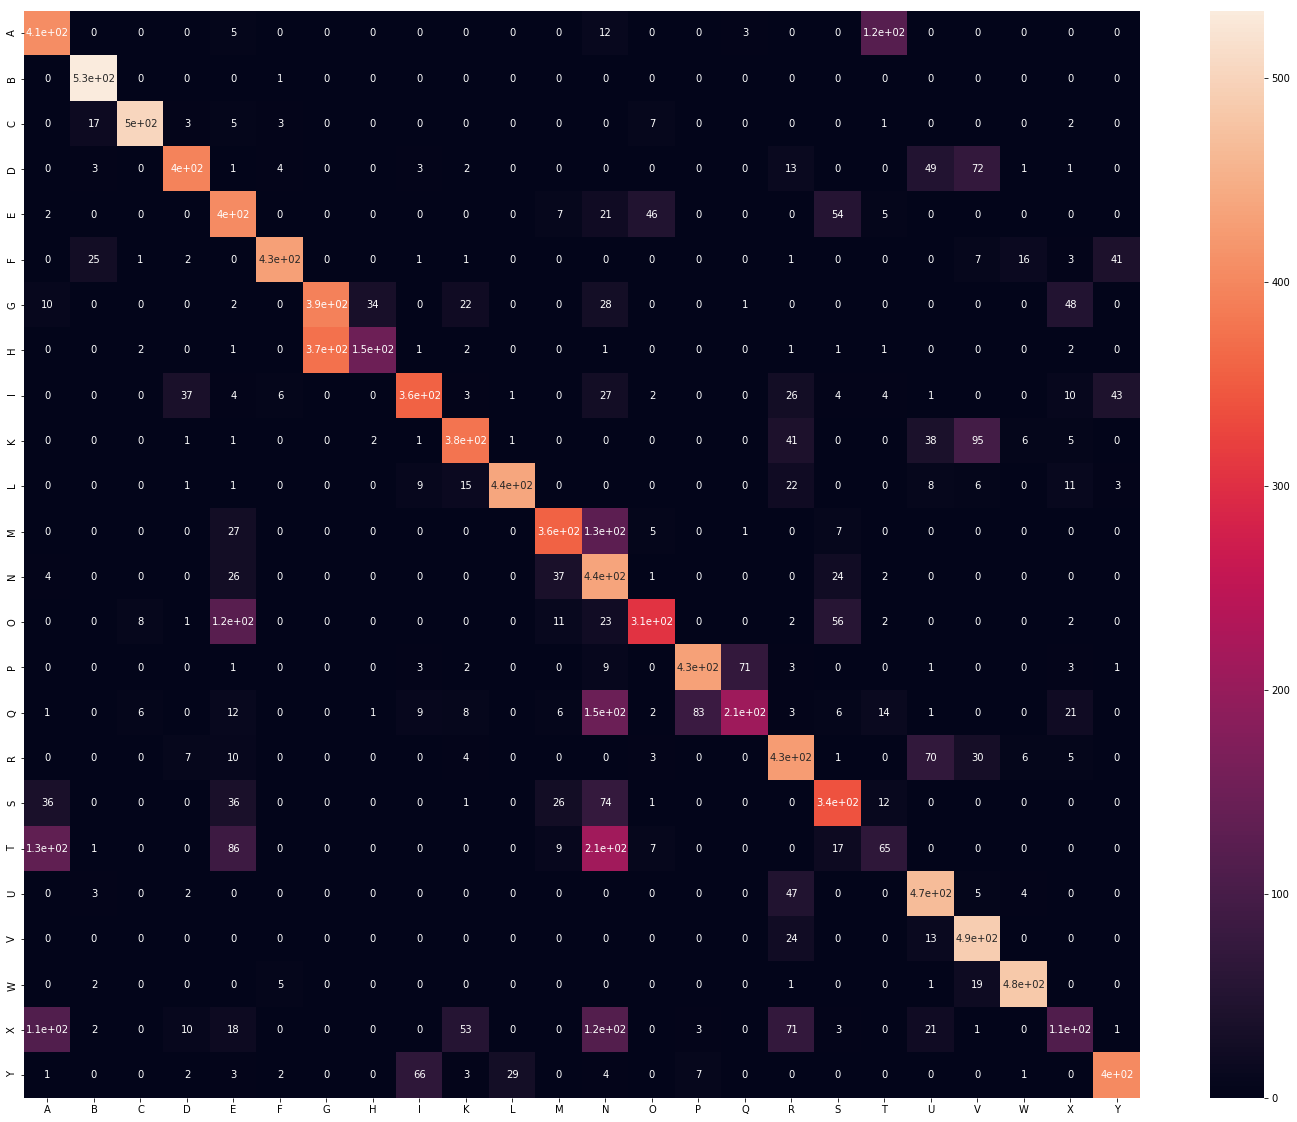

In [23]:
df_cm = pd.DataFrame(confusion_arr, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (25,20))
sn.heatmap(df_cm, annot=True)

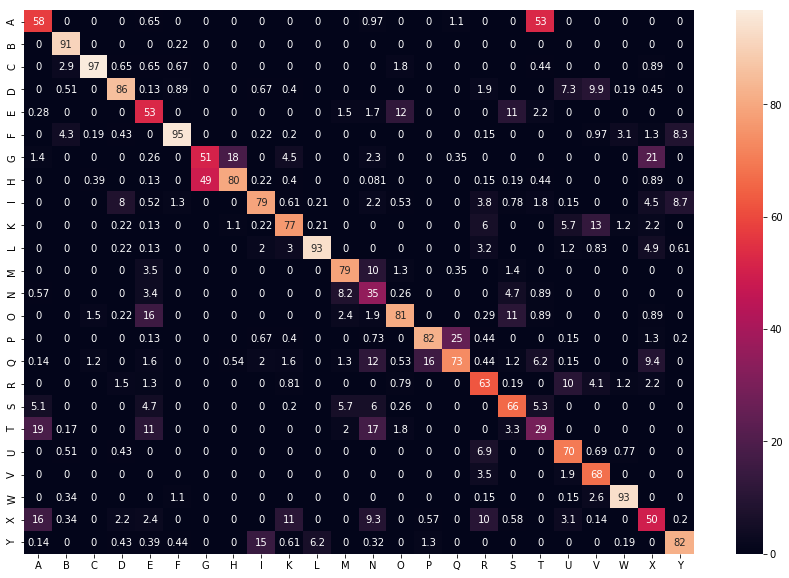

In [25]:
# Percentages for confusion matrix
# Multiplied by 100 to make it easier to read values
df_cm = pd.DataFrame(confusion_arr_percents*100, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)